# Blind source separation (BSS) of maternal and fetal ECG using ICA

BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [108]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the follwing figure are the "ECG" signals measured in different ECG leads.

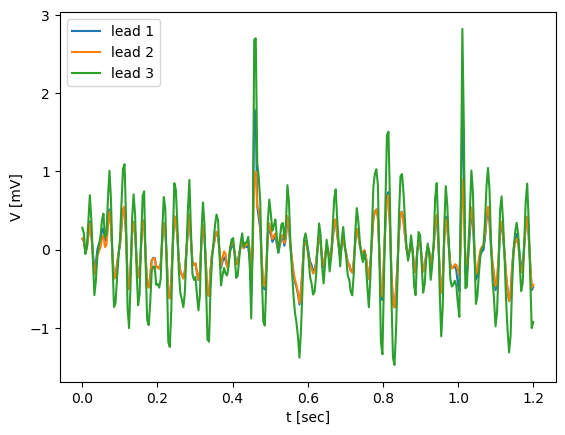

In [109]:
X = np.load('mixed_signals.npy')
Fs = 250 # [Hz]
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3\times300}\right)$ can be written as $X=AS$ where $S\in R^{3\times300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how the whitening process is relative to a machine learning algorithm that we already saw? Mention what is the ML algorithm. Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:
The whitening process is related to PCA. In PCA we look for the main component axes of the data (eigen-vector of the covariance matrix). This is the same as we doing here but, we also use those components to transform the data to make unity covarince (spherical).

The inverse of diagonal matrix is a matrix whose diagonal compose of the inverse of the elements. for example, the inverse of matrix A = [[2,0],[0,8]] is A^(-1) = [[0.5,0],[0,0.125]]

Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ row vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [110]:
def whitening(X):
    #---------------------Implement your code here:------------------------
    X_centered = (X - X.mean(axis=1).reshape((3,1))) 
    C = np.cov(X_centered)
    eig_val, P = np.linalg.eigh(C)
    D = np.diag(np.ones((3,)) / np.sqrt(eig_val))
    X_whiten = D @ P.T @ X_centered
    #----------------------------------------------------------------------
    return X_whiten 

We will now look at the covariance matrix of the whitened data:

In [111]:
X_w = whitening(X)
print(np.cov(X_w))

[[ 1.00000000e+00 -7.37901007e-14 -3.20813610e-15]
 [-7.37901007e-14  1.00000000e+00  4.86121734e-15]
 [-3.20813610e-15  4.86121734e-15  1.00000000e+00]]


Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:
Yes, they are quite close to unity matrix, there is some error due to limited sample of data - can't estimate covariance good enough.

We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$: 


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}[x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})]^3 - 3w^{(p)}_{n-1}$ 

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ row of $W$ (the $3\times3$ matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [112]:
def update_wp(w_p,X_w,W,p):
    #---------------------Implement your code here:------------------------
    w_p = (X_w * ((w_p @ X_w)**3)).mean(axis=1) - 3 * w_p  
    corr = 0
    for j in range(p):
        corr += (w_p @ W[j,:]) * W[j,:]
    w_p -= corr
    w_p /= np.linalg.norm(w_p)
    #----------------------------------------------------------------------
    return w_p

In [113]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results. 

In [114]:
#---------------------Implement your code here:------------------------
W.T @ W
#----------------------------------------------------------------------

array([[ 1.00000000e+00, -3.32680840e-18,  2.83642772e-17],
       [-3.32680840e-18,  1.00000000e+00,  2.48696597e-17],
       [ 2.83642772e-17,  2.48696597e-17,  1.00000000e+00]])

### Answer:
Since W is almost orthonormal, it multiplication with iself should give us a matrix close to the identity, which we can see that is in fact the case.

In [115]:
# Ground true sources for comparing later on
GT = np.load('groundtruth0.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

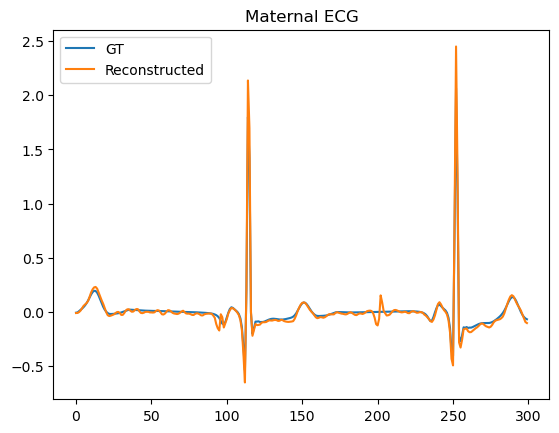

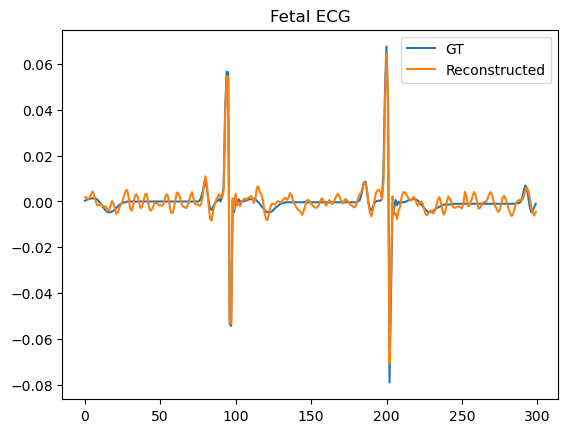

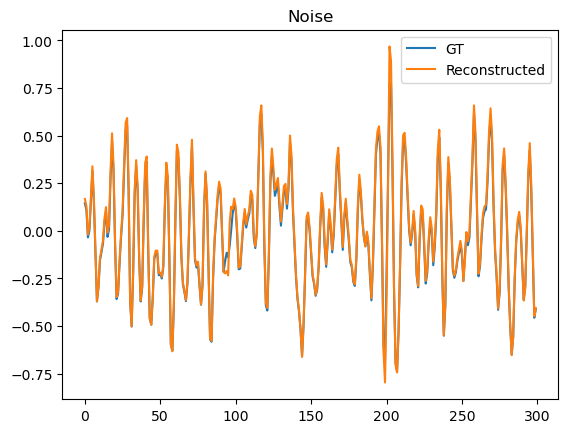

In [116]:
#---------------------Implement your code here:------------------------
S = W.T @ X_w
S_mod = np.array([
    S[1,:],
    S[0,:],
    S[2,:]
])

S_mod[0,:] *= -0.25
S_mod[1,:] *= 0.01
S_mod[2,:] *= -0.3

titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
for i in range(3):
    plt.figure(i)
    plt.plot(GT[i,:])
    plt.plot(S_mod[i,:])
    plt.legend({'GT','Reconstructed'})
    plt.title(titles[i])
#----------------------------------------------------------------------

As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

In [117]:
from sklearn.decomposition import FastICA
#---------------------Implement your code here:------------------------
ica = FastICA(n_components=3, whiten='unit-variance', random_state=0)
S_new = ica.fit_transform(X.T).T
#----------------------------------------------------------------------

Plot and compare the results to what you did. You should have pretty similar results up to scaling factors.

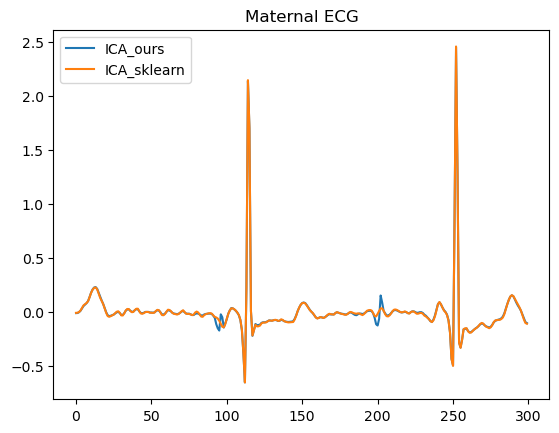

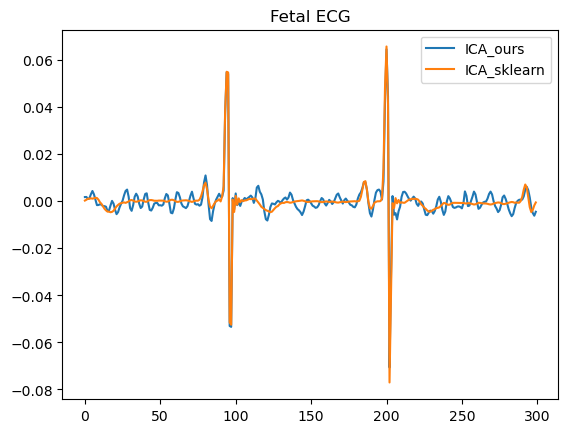

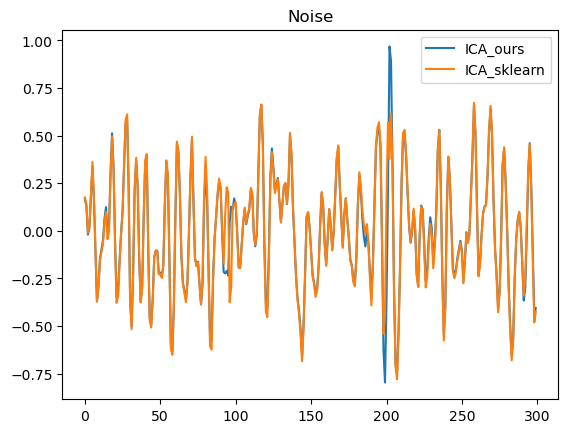

In [118]:
#---------------------Implement your code here:------------------------
S_new_mod = np.array([
    S_new[2,:],
    S_new[0,:],
    S_new[1,:]
])

S_new_mod[0,:] *= 0.25
S_new_mod[1,:] *= 0.01
S_new_mod[2,:] *= -0.3
titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
for i in range(3):
    plt.figure(i)
    plt.plot(S_mod[i,:])
    plt.plot(S_new_mod[i,:])
    plt.legend(['ICA_ours','ICA_sklearn'])
    plt.title(titles[i])
#----------------------------------------------------------------------

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [85]:
X_clean = np.load('mixed_signal12.npy')
X_clean.shape

(3, 300)

We will run again the ICA.

In [122]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

5
5
3000


These are the ground true measurements:

In [120]:
GT = np.load('groundtruth12.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above. 

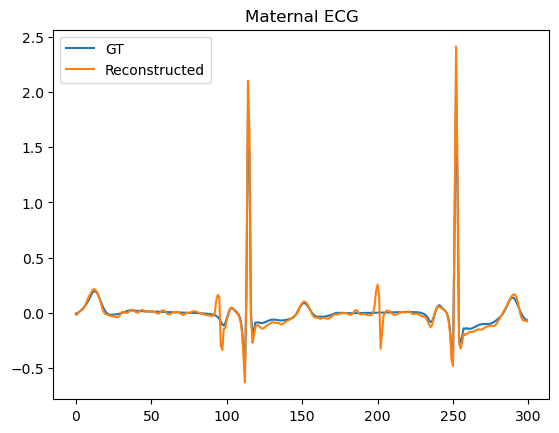

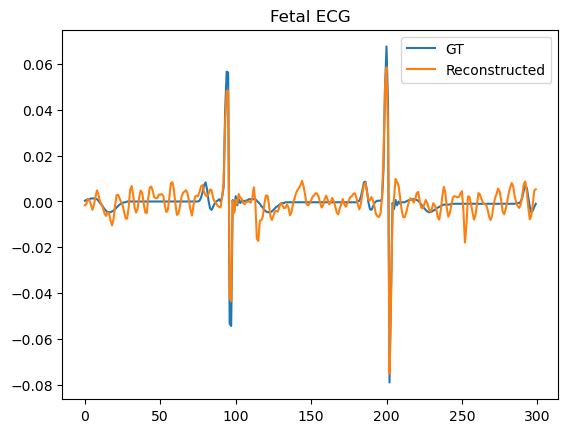

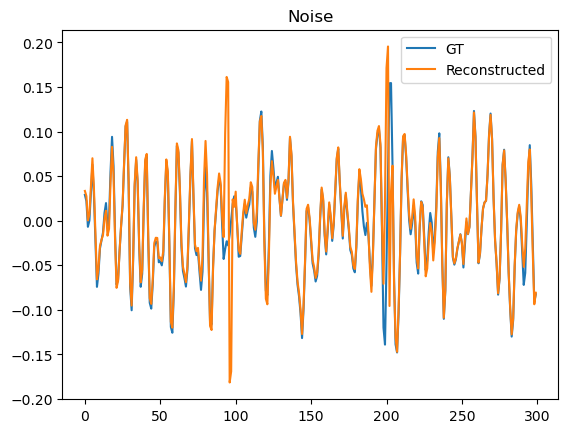

In [121]:
#---------------------Implement your code here:------------------------
S2 = W.T @ X_w
S2_mod = np.array([
    S2[1,:],
    S2[2,:],
    S2[0,:]
])

S2_mod[0,:] *= 0.25
S2_mod[1,:] *= -0.01
S2_mod[2,:] *= -0.06

titles = ['Maternal ECG', 'Fetal ECG', 'Noise']
for i in range(3):
    plt.figure(i)
    plt.plot(GT[i,:])
    plt.plot(S2_mod[i,:])
    plt.legend({'GT','Reconstructed'})
    plt.title(titles[i])
#----------------------------------------------------------------------

Did you expect better recontructio with higher SNR. If it did not happen, what could possibly explain it?

## Answer:
Yes, idealy, higher SNR should lead to better results. signals' true pattern should be more easily recuonstructed. however, we saw in the example above that it did not affected very much on the final reconstruction results. 

GOOD LUCK!